# How to verify correctness of your encoding

As described in the [background material](https://github.com/qiskit-community/prototype-qrao/blob/main/docs/background/quantum_relaxations.md), we assume for sake of the QRAO method that **the relaxation commutes with the objective function.**  This notebook demonstrates how one can verify this for any problem (a `QuadraticProgram` in the language of Qiskit Optimization).  One might want to verify this for pedagogical purposes, or as a sanity check when investigating unexpected behavior with the QRAO prototype.  Any problem that does not commute should be considered a bug, and if such a problem is discovered, we encourage that you [submit it as an issue](https://github.com/qiskit-community/prototype-qrao/issues) on GitHub.

First, we begin by importing some dependencies. The most important class introduced here is `EncodingCommutationVerifier`, which allows one to conveniently iterate over all decision variable states and compare each objective value with the corresponding encoded objective value, in order to identify any discrepancy.  We also import [tqdm](https://github.com/tqdm/tqdm) to provide a progress bar as this verification is occurring, as it requires an amount of time exponential in the number of decision variables.

In [1]:
%matplotlib inline

import numpy as np
import networkx as nx

from tqdm.notebook import tqdm

from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qrao.encoding import QuantumRandomAccessEncoding, EncodingCommutationVerifier

Next, we construct a toy max-cut problem.  Note that the resulting variable embedding has some qubits with 1, 2, and 3 decision variables.

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 40 x0 + 46 x1 + 82 x2 + 88 x3 + 178 x4 + 94 x5 + [ - 24 x0*x1 - 40 x0*x3
      - 96 x0*x5 - 64 x1*x2 - 96 x1*x4 - 120 x2*x3 - 144 x2*x4 - 192 x3*x4
      - 280 x4*x5 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End



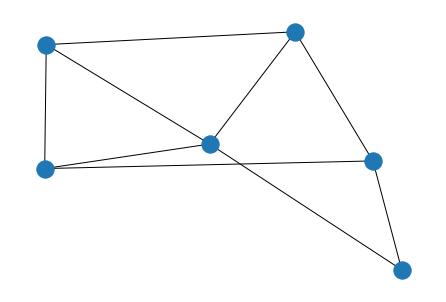

In [2]:
num_nodes = 6
elist = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0), (0, 3), (1, 4), (2, 4)]
edges = np.zeros((num_nodes, num_nodes))
for i, j in elist:
    edges[i, j] = (i + 1) * (j + 2)

mod = Model("maxcut")
nodes = list(range(num_nodes))
var = [mod.binary_var(name="x" + str(i)) for i in nodes]
mod.maximize(
    mod.sum(
        edges[i, j] * (1 - (2 * var[i] - 1) * (2 * var[j] - 1))
        for i in nodes
        for j in nodes
    )
)
graph = nx.from_edgelist(elist)
nx.draw(graph)
problem = from_docplex_mp(mod)
print(problem)

As before, we `encode()` the problem using the `QuantumRandomAccessEncoding` class:

In [3]:
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

In [4]:
print("Encoded Problem:\n=================")
print(encoding.qubit_op)  # The Hamiltonian without the offset
print("Offset = ", encoding.offset)
print("Variables encoded on each qubit: ", encoding.q2vars)

Encoded Problem:
8.999999999999998 * XXI
+ 14.999999999999998 * XYI
+ 35.99999999999999 * XZI
+ 23.999999999999996 * IXX
+ 35.99999999999999 * YXI
+ 44.99999999999999 * IYX
+ 53.99999999999999 * YIX
+ 71.99999999999999 * YYI
+ 104.99999999999999 * YZI
Offset =  -132.0
Variables encoded on each qubit:  [[0, 4], [1, 3, 5], [2]]


Finally, we iterate over every decision variable state using `EncodingCommutationVerifier` and verify that, in each case, the problem objective value matches the encoded objective value:

In [5]:
verifier = EncodingCommutationVerifier(encoding)
progress_bar = tqdm(verifier)
for str_dvars, obj_val, encoded_obj_val in progress_bar:
    if not np.isclose(encoded_obj_val, obj_val, atol=1e-4):
        progress_bar.disp(bar_style="danger")
        raise Exception(
            f"Violation identified: {str_dvars} evaluates to {obj_val} "
            f"but the encoded problem evaluates to {encoded_obj_val}."
        )

  0%|          | 0/64 [00:00<?, ?it/s]

A complete, green progress bar demonstrates that verification was successful.

If you are able to construct a problem that causes a violation, it is quite possible that you have discovered a bug in the `QuantumRandomAccessEncoding` logic.  We would greatly appreciate it if you could share the problem with us by [submitting it as an issue](https://github.com/qiskit-community/prototype-qrao/issues) on GitHub.

In [6]:
import qiskit.tools.jupyter  # pylint: disable=unused-import,wrong-import-order

%qiskit_version_table
%qiskit_copyright